In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import math

In [2]:
from descriptors import *
from vlad import *

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA

In [3]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

In [4]:
imgs, labels = load_image(True)

In [5]:
df = pd.DataFrame({"img": imgs, "label": labels})

# SIFT

In [6]:
keypoints, desc = SIFT_create(df["img"])

In [7]:
df["keypoint"] = keypoints
df["desc"] = desc
df.head()

,img,label,keypoint,desc
0,"[[139, 149, 149, 146, 149, 148, 150, 162, 78, ...",Faces_easy,"(< cv2.KeyPoint 0x7f1ac11e3180>, < cv2.KeyPoin...","[[124.0, 41.0, 1.0, 12.0, 73.0, 1.0, 0.0, 1.0,..."
1,"[[126, 122, 141, 122, 115, 103, 131, 140, 137,...",Faces_easy,"(< cv2.KeyPoint 0x7f1a995e40c0>, < cv2.KeyPoin...","[[1.0, 0.0, 0.0, 0.0, 1.0, 8.0, 8.0, 9.0, 14.0..."
2,"[[195, 195, 195, 195, 195, 195, 195, 195, 197,...",Faces_easy,"(< cv2.KeyPoint 0x7f1a995eb6c0>, < cv2.KeyPoin...","[[30.0, 0.0, 0.0, 4.0, 14.0, 0.0, 0.0, 10.0, 9..."
3,"[[58, 57, 55, 53, 51, 53, 58, 62, 96, 84, 74, ...",Faces_easy,"(< cv2.KeyPoint 0x7f1a992b47e0>, < cv2.KeyPoin...","[[7.0, 0.0, 0.0, 4.0, 25.0, 1.0, 0.0, 4.0, 30...."
4,"[[143, 64, 116, 153, 89, 29, 118, 216, 189, 20...",Faces_easy,"(< cv2.KeyPoint 0x7f1a992b7540>, < cv2.KeyPoin...","[[10.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 178..."


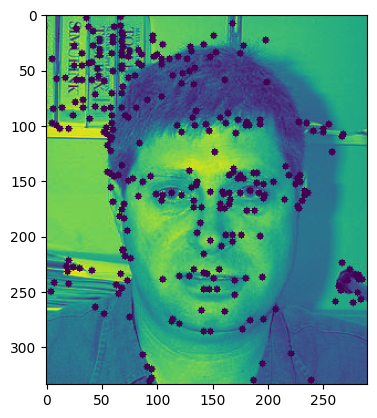

In [8]:
draw_keypoint(df["img"].iloc[0], df["keypoint"].iloc[0])

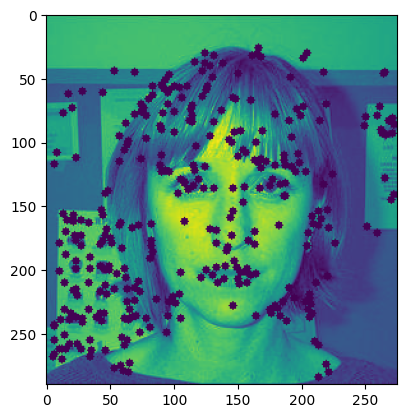

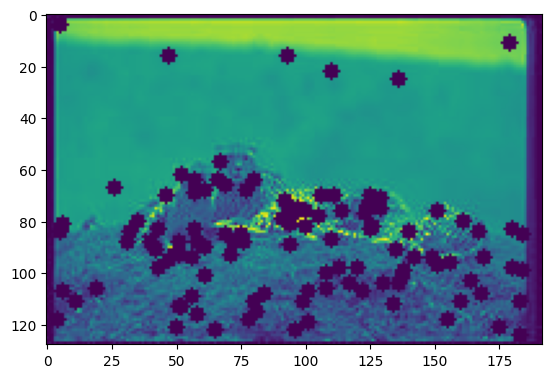

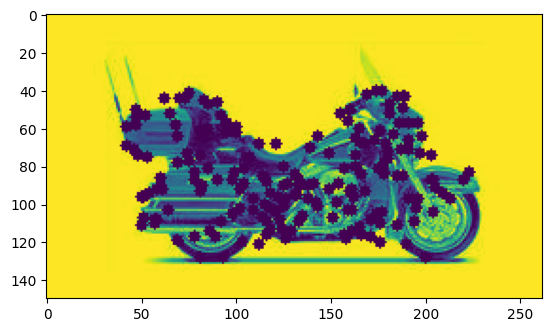

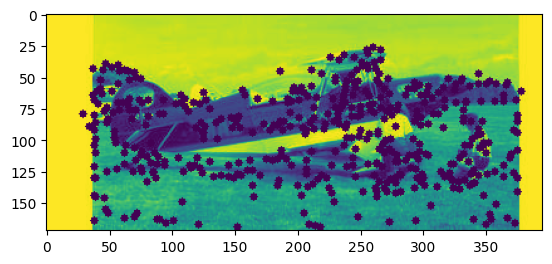

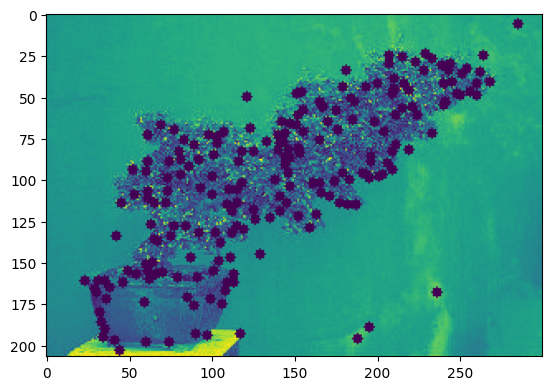

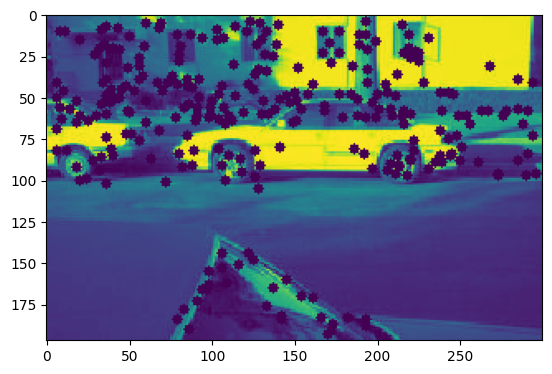

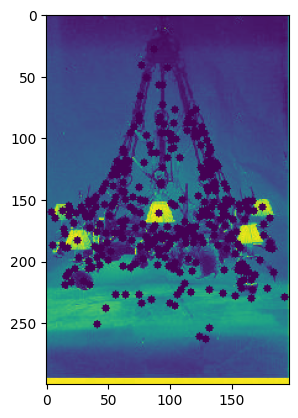

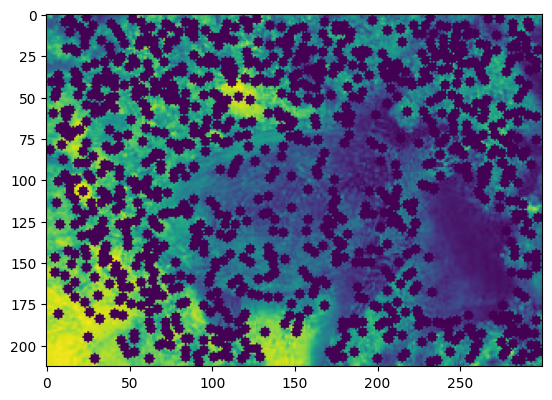

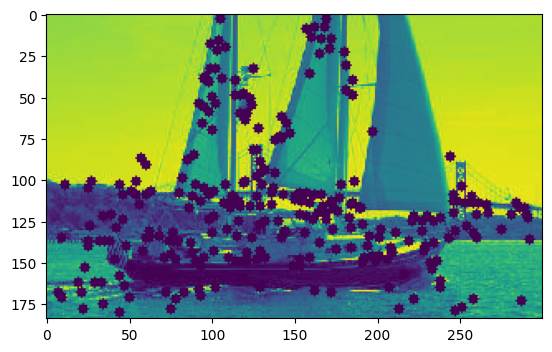

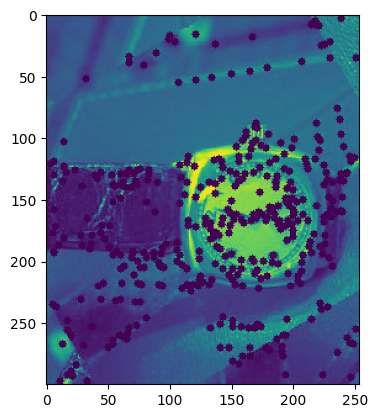

In [9]:
for cls in df["label"].unique():
    idx = random.choice(df[df["label"] == cls].index)
    
    img = imgs[idx]
    kps = keypoints[idx] 
    draw_keypoint(img, kps)

# Sacs de mots visuels

In [10]:
df.shape

(1000, 4)

Forme du tableau des histogrammes : (1000, 5000)


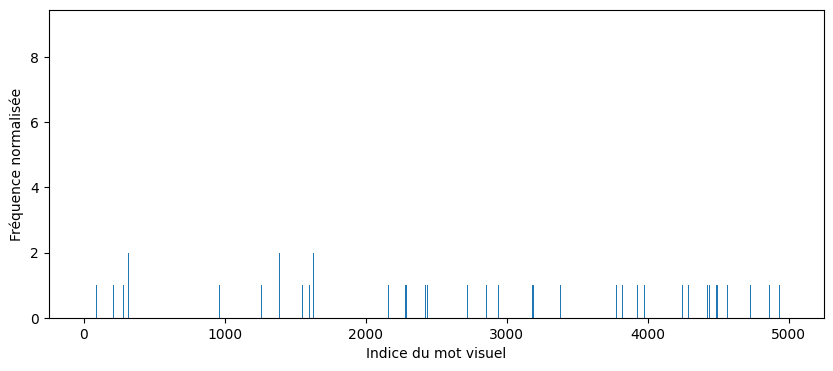

In [11]:
vocabulary = np.load("../data/vocabularies_sift/vocabulary_5000.npy")


hists = histograms_from_descriptors(df["desc"], vocabulary)
print("Forme du tableau des histogrammes :", hists.shape)
tmp = []
for idx in range(hists.shape[0]):
    tmp.append(hists[idx])
df["hist"] = tmp
plt.figure(figsize=(10,4))
plt.bar(np.arange(5000), df["hist"].iloc[0])
plt.xlabel("Indice du mot visuel")
plt.ylabel("Fréquence normalisée")
plt.show()


# Classification par sacs de mots visuels

/home/nicolas/Etude/amvo/.venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.78


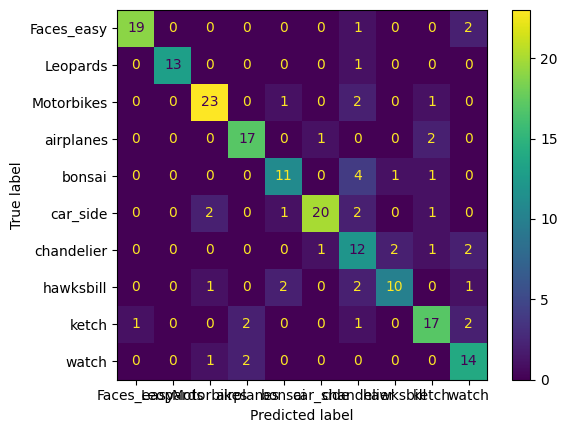

In [12]:
acc, conf = process_train_test(np.vstack(df["hist"].to_numpy()), df["label"].to_numpy())
print(f"Accuracy: {acc}")
disp = ConfusionMatrixDisplay(confusion_matrix=conf, display_labels=np.unique(labels))
disp.plot()
plt.show()

## VLAD

In [13]:
vlad_vectors = compute_all_vlad(df["desc"], vocabulary)

print("Dimension VLAD :", vlad_vectors.shape)

Dimension VLAD : (1000, 640000)


In [14]:
vlad_pca, pca_model = reduce_vlad_pca(vlad_vectors, n_components=100)
print("Dimension après ACP :", vlad_pca.shape)

Dimension après ACP : (1000, 100)


### Classification avec VLAD

In [19]:
imgs, labels = load_image(grey=False)
_, descriptors_list = SIFT_create(imgs)
vocabulary = np.load("../data/vocabularies_sift/vocabulary_5000.npy")
vlad_vectors = compute_all_vlad(descriptors_list, vocabulary)
X_train, X_test, y_train, y_test = train_test_split(
    vlad_vectors, labels, test_size=0.2, random_state=SEED
)
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
accuracy_vlad = accuracy_score(y_test, y_pred)

print("Accuracy VLAD (sans ACP) :", accuracy_vlad)


Accuracy VLAD (sans ACP) : 0.665


In [20]:
# 1. Réduction de dimension
vlad_pca, pca_model = reduce_vlad_pca(vlad_vectors, n_components=100)

# 2. Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    vlad_pca, labels, test_size=0.2, random_state=SEED
)

# 3. Classification
clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

# 4. Évaluation
y_pred = clf.predict(X_test)
accuracy_vlad_pca = accuracy_score(y_test, y_pred)

print("Accuracy VLAD + ACP :", accuracy_vlad_pca)


Accuracy VLAD + ACP : 0.705
